<a href="https://colab.research.google.com/github/Marzkartella/Tella/blob/main/Sale%2C_Customer_Segmentation_Untitled12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1340]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [1341]:
# Load the dataset
file_path = "/content/data.csv"
CS = pd.read_csv(file_path, encoding='latin-1') # Changed encoding to 'latin-1'


In [1342]:
# Display basic info to understand the structure
CS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [1343]:
CS.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [1344]:
CS.tail()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [1345]:
CS.describe()


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [1346]:
CS.shape


(541909, 8)

In [1347]:
# Preview categorical (object) columns
CS.select_dtypes(include='object').columns.tolist()


['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']

In [1348]:
# Check for missing values
CS.isnull().sum()


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [1349]:
# Drop duplicates
CS.drop_duplicates()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [1350]:
# Drop 'Description' and 'CustomerID' columns
CS.drop(columns=['Description', 'CustomerID'])

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country
0,536365,85123A,6,12/1/2010 8:26,2.55,United Kingdom
1,536365,71053,6,12/1/2010 8:26,3.39,United Kingdom
2,536365,84406B,8,12/1/2010 8:26,2.75,United Kingdom
3,536365,84029G,6,12/1/2010 8:26,3.39,United Kingdom
4,536365,84029E,6,12/1/2010 8:26,3.39,United Kingdom
...,...,...,...,...,...,...
541904,581587,22613,12,12/9/2011 12:50,0.85,France
541905,581587,22899,6,12/9/2011 12:50,2.10,France
541906,581587,23254,4,12/9/2011 12:50,4.15,France
541907,581587,23255,4,12/9/2011 12:50,4.15,France


In [1351]:
# Count unique values in each column
CS.nunique()

,0
InvoiceNo,25900
StockCode,4070
Description,4223
Quantity,722
InvoiceDate,23260
UnitPrice,1630
CustomerID,4372
Country,38


In [1352]:
# Extract transactions where Quantity < 0 (Cancelled)
C_CS = CS[CS['Quantity'] < 0]

# Display results
C_CS


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [1353]:
# Unique country names
unique_countries = CS['Country'].unique()

# Display results
unique_countries


array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [1354]:
# Categorical data types
categorical_types = CS.select_dtypes(include='object').dtypes

# Display results
categorical_types

,0
InvoiceNo,object
StockCode,object
Description,object
InvoiceDate,object
Country,object


In [1355]:
# Output quantity column
quantity_column = CS['Quantity']

# Display results
quantity_column


,Quantity
0,6
1,6
2,8
3,6
4,6
...,...
541904,12
541905,6
541906,4
541907,4


In [1356]:
# Transactions that start with 'C' in InvoiceNo (Cancelled)
cancelled_transactions = CS[CS['InvoiceNo'].str.startswith('C')]
cancelled_variable = cancelled_transactions.copy()

# Display results
cancelled_transactions


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [1357]:
cancelled_transactions.copy

<bound method NDFrame.copy of        InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

            InvoiceDate  UnitPrice  CustomerID         Country  
141      12/1/2010 9:41      27.50     14527.0  United Kingdom  
154      12/1/2010 9:49       4.65     15311.0  United Kingdom  
235     12/1/2010 10:24       1.65     17548.0  United Kingdom  
236     12/1/2010 10:24       0.29     17548.0  United Kingdom  
237     12/1/2010 10:24       0.29     17548.0  United Kingdom  
...                 ...        ...         ...             ...  
540449   12/9/2011 9:57       0.83     14397.0  United Kingdom  
541541  12/9/2011 10:28     224.69     15498.0  United Kingdom  
541715  12/9/2011 11:57      10.95     15311.0  United Kingdom  
541716  12/9/2011 11:58       1.25     17315.0  United Kingdom  
541717  12/9/2011 11:58       1.25     17315.0  United Kingdom  

[9288 rows x 8 columns]>

In [1358]:
# Percentage of Cancelled Transactions
percentage_cancelled = len(cancelled_transactions) / len(CS) * 100

# Display results
percentage_cancelled


1.7139409015166756

In [1359]:
# Unique StockCodes
unique_stockcodes = CS['StockCode'].unique()

# Display results
unique_stockcodes


array(['85123A', '71053', '84406B', ..., '90214U', '47591b', '23843'],
      dtype=object)

In [1360]:
# StockCode with highest quantity
stockcode_max_quantity = CS.groupby('StockCode')['Quantity'].sum().idxmax()
stockcode_max_quantity_value = CS.groupby('StockCode')['Quantity'].sum().max()

# Display results
stockcode_max_quantity,
stockcode_max_quantity_value,
len(unique_stockcodes)


4070

In [1361]:
# Display results
stockcode_max_quantity_value


56450

In [1362]:
# Display results
len(unique_stockcodes)


4070

In [1363]:
# Ensure 'Quantity' is numeric (already int64, so this is a safeguard)
CS['Quantity'] = pd.to_numeric(CS['Quantity'], errors='coerce')

CS['Quantity']

,Quantity
0,6
1,6
2,8
3,6
4,6
...,...
541904,12
541905,6
541906,4
541907,4


In [1364]:
# Drop rows with invalid (NaN) 'Quantity'
CS = CS.dropna(subset=['Quantity'])

CS

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


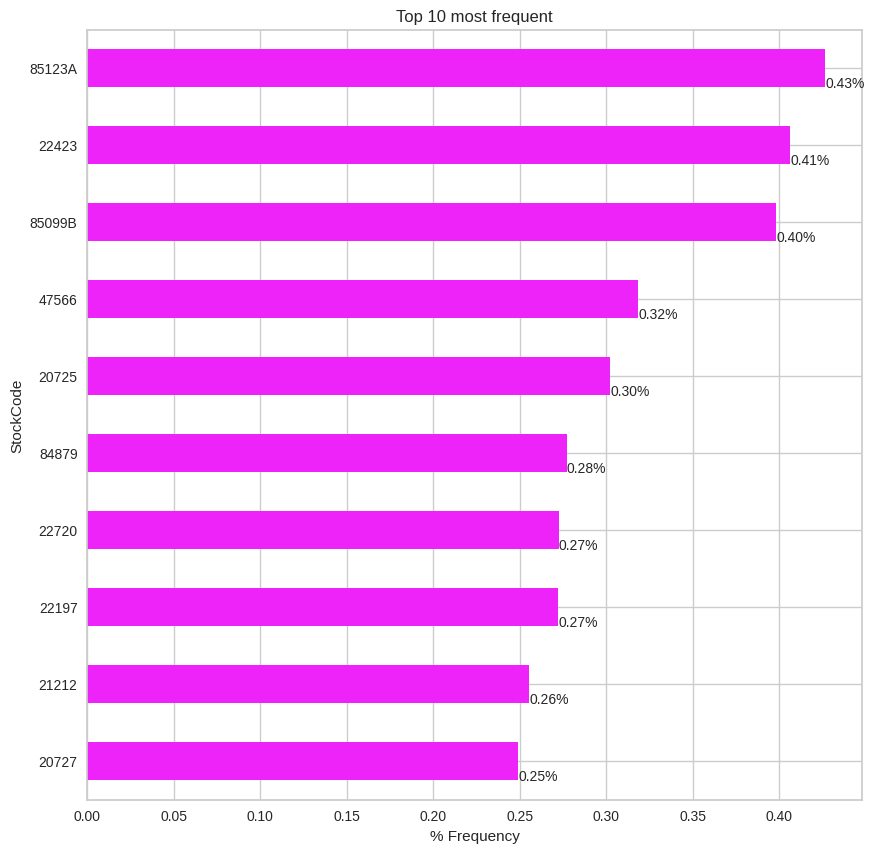

In [1365]:
# Top 10 most frequent items on store in percentage
top_10_item_percentage = CS["StockCode"].value_counts(normalize=True).head(10) * 100
plt.figure(figsize=(10, 10))
top_10_item_percentage.plot(kind='barh', color= "#ed23fa")

for index, value in enumerate(top_10_item_percentage):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title("Top 10 most frequent")
plt.xlabel("% Frequency")
plt.ylabel('StockCode')
plt.gca().invert_yaxis()
plt.show()

In [1366]:
# Group by 'StockCode, Description' and sum 'Quantity'
stockcode_quantity = CS.groupby(['StockCode','Description'])['Quantity'].sum().sort_values(ascending=False)

stockcode_quantity

,,Quantity
StockCode,Description,
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
85099B,JUMBO BAG RED RETROSPOT,47363
84879,ASSORTED COLOUR BIRD ORNAMENT,36381
22197,POPCORN HOLDER,36334
21212,PACK OF 72 RETROSPOT CAKE CASES,36039
...,...,...
20713,wrongly marked. 23343 in box,-3100
79323W,"Unsaleable, destroyed.",-4830
72140F,throw away,-5368


In [1367]:
# Top 10 most frequent items by quantity
top10_stockcode_quantity = stockcode_quantity.sort_values(ascending=False).head(10)

top10_stockcode_quantity

,,Quantity
StockCode,Description,
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
85099B,JUMBO BAG RED RETROSPOT,47363
84879,ASSORTED COLOUR BIRD ORNAMENT,36381
22197,POPCORN HOLDER,36334
21212,PACK OF 72 RETROSPOT CAKE CASES,36039
85123A,WHITE HANGING HEART T-LIGHT HOLDER,35025
23084,RABBIT NIGHT LIGHT,30680
22492,MINI PAINT SET VINTAGE,26437
22616,PACK OF 12 LONDON TISSUES,26315


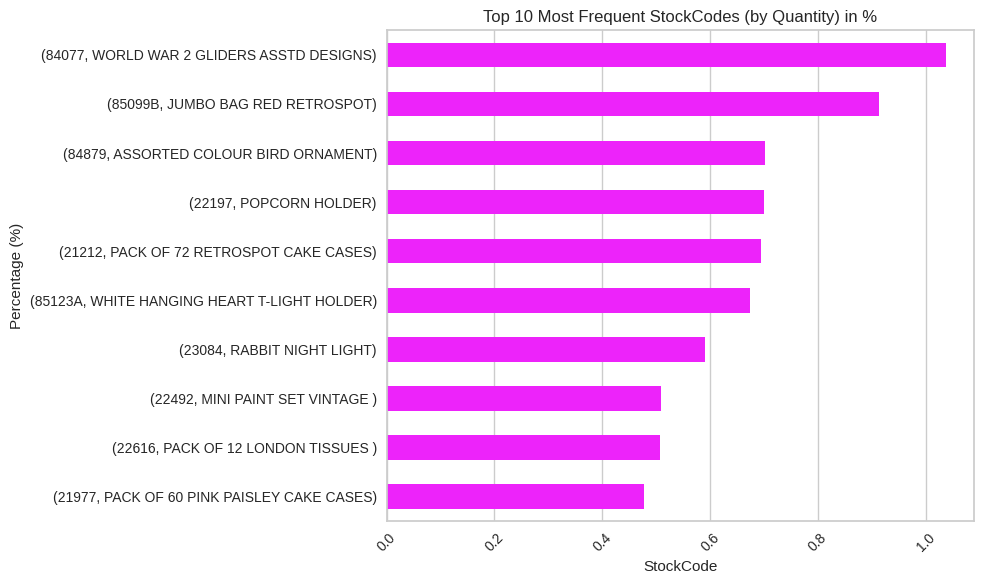

,,Quantity
StockCode,Description,
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1.037503
85099B,JUMBO BAG RED RETROSPOT,0.912572
84879,ASSORTED COLOUR BIRD ORNAMENT,0.700975
22197,POPCORN HOLDER,0.700069
21212,PACK OF 72 RETROSPOT CAKE CASES,0.694385
85123A,WHITE HANGING HEART T-LIGHT HOLDER,0.674848
23084,RABBIT NIGHT LIGHT,0.591130
22492,MINI PAINT SET VINTAGE,0.509378
22616,PACK OF 12 LONDON TISSUES,0.507027


In [1368]:
# Percentage frequency of top 10 items
top10_percentage = (top10_stockcode_quantity / stockcode_quantity.sum()) * 100


# Plotting
plt.figure(figsize=(10, 6))
top10_percentage.plot(kind='barh', color='#ed23fa')
plt.title('Top 10 Most Frequent StockCodes (by Quantity) in %')
plt.ylabel('Percentage (%)')
plt.xlabel('StockCode')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

top10_percentage

In [1369]:
# Country-related analysis
country_unique = CS['Country'].unique()


# Output summary
country_unique


array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [1370]:
# Country-related analysis
country_nunique = CS['Country'].nunique()

# Output summary
country_nunique

38

In [1371]:
# Country-related analysis
country_value_counts = CS['Country'].value_counts()

# Output summary
country_value_counts.head()

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533


In [1372]:
# Identify unspecified countries (if any)
unspecified = CS[CS['Country'].str.lower().str.contains("unspecified")]

# Remove rows with unspecified country
CS = CS[~CS['Country'].str.lower().str.contains("unspecified")]

# Output summary
unspecified


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152712,549687,20685,DOORMAT RED RETROSPOT,2,4/11/2011 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,4/11/2011 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,4/11/2011 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,4/11/2011 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,4/11/2011 13:29,0.55,12363.0,Unspecified
...,...,...,...,...,...,...,...,...
498778,578539,22560,TRADITIONAL MODELLING CLAY,24,11/24/2011 14:55,1.25,NaN,Unspecified
498779,578539,23570,TRADITIONAL PICK UP STICKS GAME,12,11/24/2011 14:55,1.25,NaN,Unspecified
498780,578539,23571,TRADITIONAL NAUGHTS & CROSSES,12,11/24/2011 14:55,1.65,NaN,Unspecified
498781,578539,84992,72 SWEETHEART FAIRY CAKE CASES,24,11/24/2011 14:55,0.55,NaN,Unspecified


In [1373]:
# Output summary
CS

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [1374]:
# Unique descriptions (reloading since 'Description' was dropped earlier)
# Reload original dataset for this specific step
Original_CS = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')

unique_desc = Original_CS['Description'].dropna().unique()

# Output summary
{
    "Unique Descriptions Count":len(unique_desc)
}

{'Unique Descriptions Count': 4223}

In [1375]:
# List of descriptions with lowercase characters
df1 = [desc for desc in unique_desc if any(char.islower() for char in desc)]

# Output summary
{
    "Descriptions with Lowercase Letters": df1[:5]
}

{'Descriptions with Lowercase Letters': ['Discount',
  'BAG 500g SWIRLY MARBLES',
  'POLYESTER FILLER PAD 45x45cm',
  'BAG 125g SWIRLY MARBLES',
  'BAG 250g SWIRLY MARBLES']}

In [1376]:
# Drop specific descriptions
drop_list = ['Bank Charges', 'Next Day Carriage', 'High Resolution Image']
Original_CS = Original_CS[~Original_CS['Description'].isin(drop_list)]


# Output summary
{
    "Dropped Descriptions": drop_list
}

{'Dropped Descriptions': ['Bank Charges',
  'Next Day Carriage',
  'High Resolution Image']}

In [1377]:
# Convert InvoiceDate to datetime
Original_CS['InvoiceDate'] = pd.to_datetime(CS['InvoiceDate'], errors='coerce')

# Extract month from InvoiceDate and create 'InvoiceMonth' column
Original_CS['InvoiceMonth'] = Original_CS['InvoiceDate'].dt.month # Create the 'InvoiceMonth' column here

# Output summary
Original_CS['InvoiceMonth'].dropna().unique()


array([12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [1378]:
# Convert InvoiceDate to datetime
#original_CS['InvoiceDate'] = pd.to_datetime(original_CS['InvoiceDate'], errors='coerce')

# Output summary
#{
   # "Sample Invoice Months": original_CS['InvoiceMonth'].dropna().unique()
#}

In [1379]:
# Extract month from InvoiceDate
#original_CS['InvoiceMonth'] = original_CS['InvoiceDate'].dt.month

# Output summary
#{
  #  "Sample Invoice Months": original_CS['InvoiceMonth'].dropna().unique()
#}

In [1380]:
# Find entries with UnitPrice == 0
CCS = Original_CS[Original_CS['UnitPrice'] == 0]

CCS

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,12.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,12.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,12.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,12.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,12.0
...,...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,12.0
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom,12.0
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom,12.0
538554,581408,85175,NaN,20,2011-12-08 14:06:00,0.0,NaN,United Kingdom,12.0


In [1381]:
# Detect outlier stockcodes (only 0 or 1 digit)
S_uniq = Original_CS['StockCode'].unique()
outlier_stockcode = [code for code in S_uniq if sum(c.isdigit() for c in str(code)) in (0, 1)]


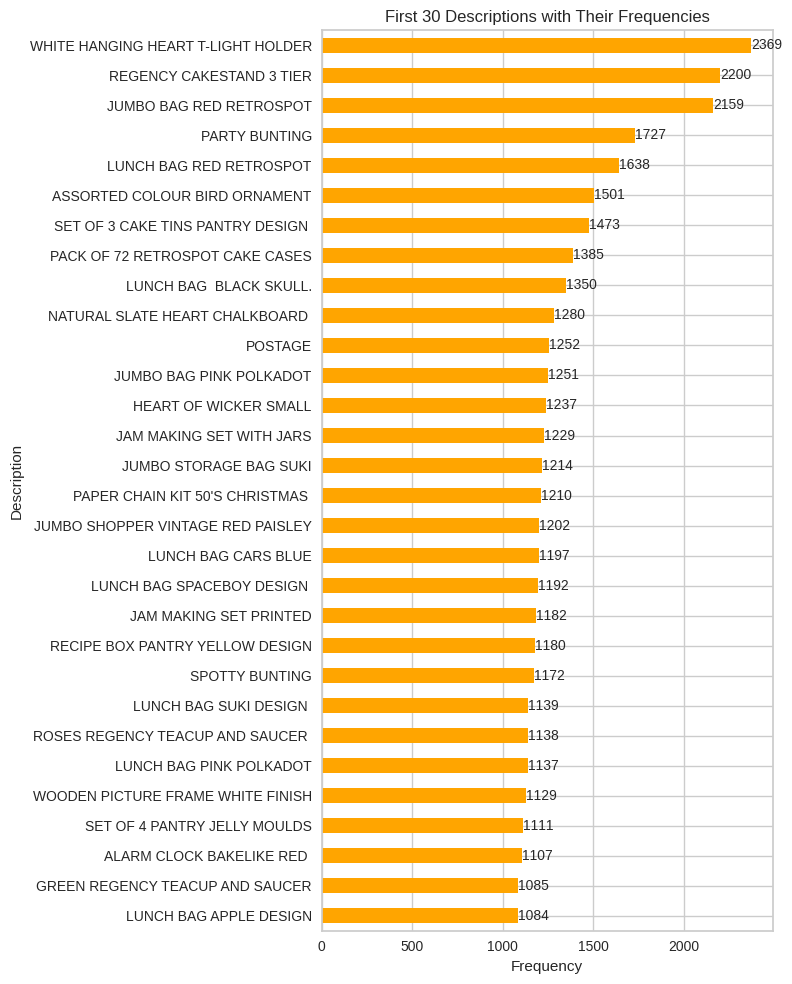

In [1382]:
# Top 30 most frequent descriptions
desc_30 = Original_CS['Description'].value_counts().head(30)

# Plotting barh chart for top 30 descriptions
plt.figure(figsize=(8, 10))
desc_30.plot(kind='barh', color='orange')
plt.title('First 30 Descriptions with Their Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Description')
plt.gca().invert_yaxis()

# Annotate bar chart with values
for index, value in enumerate(desc_30):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [1383]:
# Output summary bar chart with values

{
    "Free UnitPrice Entries": len(CCS),
    "Outlier StockCodes Count": len(outlier_stockcode),
    "Outlier Sample": outlier_stockcode[:5]
}


{'Free UnitPrice Entries': 2515,
 'Outlier StockCodes Count': 13,
 'Outlier Sample': ['POST', 'D', 'C2', 'DOT', 'M']}

In [1384]:
# Remove rows with outlier stockcodes
CS = original_CS[~original_CS['StockCode'].isin(outlier_stockcode)]

In [1385]:
# Add 'Transactional Status' column
CS['Transactional Status'] = CS['Quantity'].apply(lambda c: 'Cancelled' if c < 0 else 'Complete')

In [1386]:
# Transactional Status counts
transaction_status_counts = CS['Transactional Status'].value_counts()

Text(0.5, 1.0, 'Unit Price Distribution')

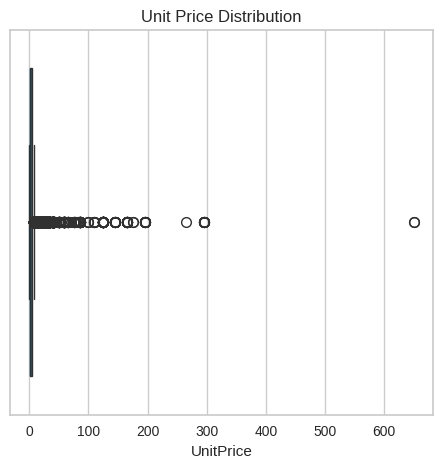

In [1387]:
# Boxplots for UnitPrice
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=CS['UnitPrice'])
plt.title('Unit Price Distribution')



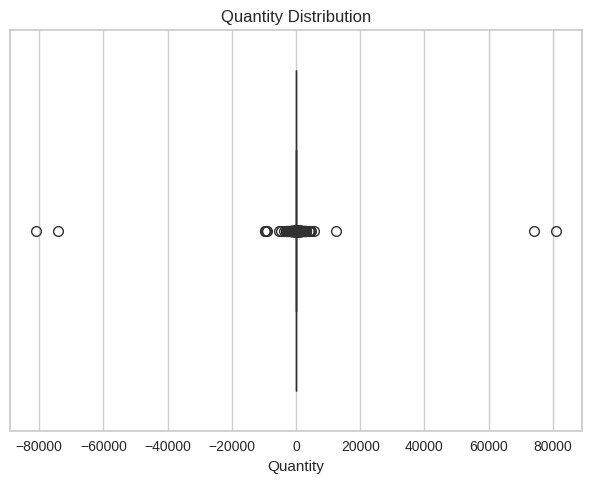

In [1388]:
# Boxplots for Quantity
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.boxplot(x=CS['Quantity'])
plt.title('Quantity Distribution')

plt.tight_layout()
plt.show()

In [1389]:
# Calculate IQR for Quantity and UnitPrice
Q1_quantity = CS['Quantity'].quantile(0.25)
Q3_quantity = CS['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

Q1_price = CS['UnitPrice'].quantile(0.25)
Q3_price = CS['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

In [1390]:
# Czech Republic-specific analysis
target_Czech_Republic = CS[CS['Country'] == 'Czech Republic'].copy()
target_Czech_Republic["Year"] = target_Czech_Republic["InvoiceDate"].dt.year

# Quantity grouped by multiple dimensions
QuantityPerDescription = target_Czech_Republic.groupby(
    ['Description', 'CustomerID', 'Year', 'InvoiceMonth', 'StockCode']
)['Quantity'].sum().reset_index()



In [1391]:
target_Czech_Republic

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,Transactional Status,Year
103598,545072,22930,BAKING MOULD HEART MILK CHOCOLATE,18,2011-02-28 08:43:00,2.55,12781.0,Czech Republic,2,Complete,2011
103599,545072,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,48,2011-02-28 08:43:00,0.65,12781.0,Czech Republic,2,Complete,2011
103600,545072,22216,T-LIGHT HOLDER WHITE LACE,24,2011-02-28 08:43:00,0.85,12781.0,Czech Republic,2,Complete,2011
103601,545072,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2011-02-28 08:43:00,1.25,12781.0,Czech Republic,2,Complete,2011
103602,545072,22231,JIGSAW TREE WITH BIRDHOUSE,36,2011-02-28 08:43:00,1.45,12781.0,Czech Republic,2,Complete,2011
103603,545072,22250,DECORATION BUTTERFLY MAGIC GARDEN,32,2011-02-28 08:43:00,0.85,12781.0,Czech Republic,2,Complete,2011
103604,545072,84459A,PINK METAL CHICKEN HEART,24,2011-02-28 08:43:00,1.49,12781.0,Czech Republic,2,Complete,2011
103605,545072,20972,PINK CREAM FELT CRAFT TRINKET BOX,24,2011-02-28 08:43:00,1.25,12781.0,Czech Republic,2,Complete,2011
103606,545072,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,2011-02-28 08:43:00,2.95,12781.0,Czech Republic,2,Complete,2011
103607,545072,21428,SET3 BOOK BOX GREEN GINGHAM FLOWER,12,2011-02-28 08:43:00,4.25,12781.0,Czech Republic,2,Complete,2011


In [1392]:
target_Czech_Republic["Year"]

,Year
103598,2011
103599,2011
103600,2011
103601,2011
103602,2011
103603,2011
103604,2011
103605,2011
103606,2011
103607,2011


In [1393]:
QuantityPerDescription

,Description,CustomerID,Year,InvoiceMonth,StockCode,Quantity
0,12 PENCILS SMALL TUBE RED RETROSPOT,12781.0,2011,10,20975,24
1,12 PENCILS SMALL TUBE SKULL,12781.0,2011,10,20974,24
2,3 HOOK HANGER MAGIC GARDEN,12781.0,2011,2,22244,12
3,ASSORTED COLOUR LIZARD SUCTION HOOK,12781.0,2011,10,47421,24
4,BAKING MOULD HEART MILK CHOCOLATE,12781.0,2011,2,22930,18
5,CHRISTMAS TABLE SILVER CANDLE SPIKE,12781.0,2011,10,23271,48
6,COLOUR GLASS T-LIGHT HOLDER HANGING,12781.0,2011,2,84755,48
7,CREAM FELT EASTER EGG BASKET,12781.0,2011,2,85206A,24
8,DECORATION BUTTERFLY MAGIC GARDEN,12781.0,2011,2,22250,32
9,FELTCRAFT HAIRBAND RED AND BLUE,12781.0,2011,2,22587,24


In [1394]:
#Summary

{
    "Transaction Status Counts": transaction_status_counts.to_dict(),
    "Quantity IQR": IQR_quantity,
    "UnitPrice IQR": IQR_price,
    "Czech Republic Data Points": len(target_Czech_Republic),
    "Grouped Quantity Data Sample": QuantityPerDescription.head(3).to_dict(orient="records")
}

{'Transaction Status Counts': {'Complete': 528847, 'Cancelled': 10039},
 'Quantity IQR': np.float64(9.0),
 'UnitPrice IQR': np.float64(2.88),
 'Czech Republic Data Points': 28,
 'Grouped Quantity Data Sample': [{'Description': '12 PENCILS SMALL TUBE RED RETROSPOT',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 10,
   'StockCode': '20975',
   'Quantity': 24},
  {'Description': '12 PENCILS SMALL TUBE SKULL',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 10,
   'StockCode': '20974',
   'Quantity': 24},
  {'Description': '3 HOOK HANGER MAGIC GARDEN',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 2,
   'StockCode': '22244',
   'Quantity': 12}]}

Text(0.5, 1.0, 'Unit Price Distribution')

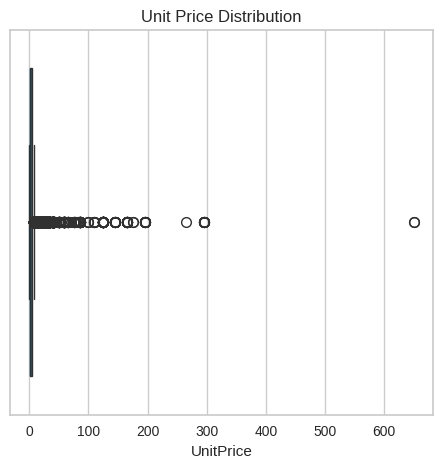

In [1395]:
# Re-run the boxplot visualizations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=CS['UnitPrice'])
plt.title('Unit Price Distribution')

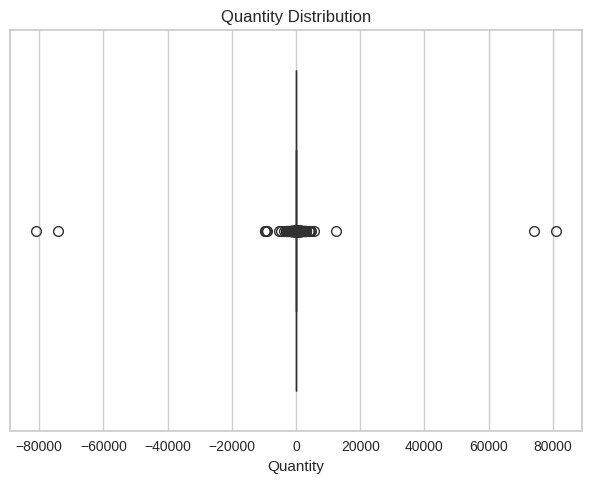

In [1396]:
# Re-run the boxplot visualizations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.boxplot(x=CS['Quantity'])
plt.title('Quantity Distribution')

plt.tight_layout()
plt.show()

In [1397]:
# Re-outputting previous summary data
{
    "Transaction Status Counts": transaction_status_counts.to_dict(),
    "Quantity IQR": IQR_quantity,
    "UnitPrice IQR": IQR_price,
    "Czech Republic Data Points": len(target_Czech_Republic),
    "Grouped Quantity Data Sample": QuantityPerDescription.head(3).to_dict(orient="records")
}


{'Transaction Status Counts': {'Complete': 528847, 'Cancelled': 10039},
 'Quantity IQR': np.float64(9.0),
 'UnitPrice IQR': np.float64(2.88),
 'Czech Republic Data Points': 28,
 'Grouped Quantity Data Sample': [{'Description': '12 PENCILS SMALL TUBE RED RETROSPOT',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 10,
   'StockCode': '20975',
   'Quantity': 24},
  {'Description': '12 PENCILS SMALL TUBE SKULL',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 10,
   'StockCode': '20974',
   'Quantity': 24},
  {'Description': '3 HOOK HANGER MAGIC GARDEN',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 2,
   'StockCode': '22244',
   'Quantity': 12}]}

In [1398]:
# Recalculate IQR values
Q1_quantity = CS['Quantity'].quantile(0.25)
Q3_quantity = CS['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

Q1_price = CS['UnitPrice'].quantile(0.25)
Q3_price = CS['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Czech Republic filter and group by aggregation (redefining for continuity)
target_Czech_Republic = CS[CS['Country'] == 'Czech Republic'].copy()
target_Czech_Republic["Year"] = target_Czech_Republic["InvoiceDate"].dt.year

QuantityPerDescription = target_Czech_Republic.groupby(
    ['Description', 'CustomerID', 'Year', 'InvoiceMonth', 'StockCode']
)['Quantity'].sum().reset_index()

# Recompute Transactional Status Counts
transaction_status_counts = CS['Transactional Status'].value_counts()

# Output final results
{
    "Transaction Status Counts": transaction_status_counts.to_dict(),
    "Quantity IQR": IQR_quantity,
    "UnitPrice IQR": IQR_price,
    "Czech Republic Data Points": len(target_Czech_Republic),
    "Grouped Quantity Data Sample": QuantityPerDescription.head(3).to_dict(orient="records")
}


{'Transaction Status Counts': {'Complete': 528847, 'Cancelled': 10039},
 'Quantity IQR': np.float64(9.0),
 'UnitPrice IQR': np.float64(2.88),
 'Czech Republic Data Points': 28,
 'Grouped Quantity Data Sample': [{'Description': '12 PENCILS SMALL TUBE RED RETROSPOT',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 10,
   'StockCode': '20975',
   'Quantity': 24},
  {'Description': '12 PENCILS SMALL TUBE SKULL',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 10,
   'StockCode': '20974',
   'Quantity': 24},
  {'Description': '3 HOOK HANGER MAGIC GARDEN',
   'CustomerID': 12781.0,
   'Year': 2011,
   'InvoiceMonth': 2,
   'StockCode': '22244',
   'Quantity': 12}]}